In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

In [ ]:
DataPath = '/content/drive/My Drive/Project/Fish_Dataset_Augmented/train'
classes = [i for i in os.listdir(DataPath) if os.path.isdir(os.path.join(DataPath, i))]
classes

['Senangin',
 'Gelama',
 'Jenahak',
 'Merah',
 'Siakap',
 'Cencaru',
 'Kembong',
 'Kerisi',
 'Sardin',
 'Tamok',
 'Sebelah',
 'DaunBaru',
 'SelarKuning',
 'TilapiaMerah',
 'BawalEmas']

In [ ]:
label = []
path = []
for dirname, _, filenames in os.walk(DataPath):
    for filename in filenames:
        if os.path.splitext(filename)[-1].lower() in ['.JPG', '.jpg', '.png']:
            label.append(os.path.split(dirname)[-1])
            path.append(os.path.join(dirname, filename))
df = pd.DataFrame(columns=['path', 'label'])
df['path'] = path
df['label'] = label

In [ ]:
df['label'].value_counts()

Senangin        300
Gelama          300
Jenahak         300
Merah           300
Siakap          300
Cencaru         300
Kembong         300
Kerisi          300
Sardin          300
Tamok           300
Sebelah         300
DaunBaru        300
SelarKuning     300
TilapiaMerah    300
BawalEmas       300
Name: label, dtype: int64

In [ ]:
num_unique_labels = len(df['label'].unique())
num_rows = 3
num_cols = 3

idx = 0
plt.figure(figsize=(20, 20), facecolor='black')
plt.style.use('dark_background')
for unique_label in df['label'].unique():
    if idx < num_rows * num_cols:
        plt.subplot(num_rows, num_cols, idx + 1)
        img = plt.imread(df[df['label'] == unique_label].iloc[0, 0])
        plt.imshow(img)
        plt.title(unique_label, fontsize=20, color='white')
        plt.axis('off')
        idx += 1
    else:
        break
plt.tight_layout(pad=2, w_pad=1, h_pad=1)
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
train_df, test_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42)

In [ ]:
test_df['label'].value_counts()

Gelama          66
Senangin        65
TilapiaMerah    65
BawalEmas       65
Tamok           64
Sardin          63
Merah           62
Kerisi          61
Siakap          59
Jenahak         59
Cencaru         58
SelarKuning     57
DaunBaru        54
Sebelah         53
Kembong         49
Name: label, dtype: int64

In [ ]:
train_df['label'].value_counts()

Kembong         251
Sebelah         247
DaunBaru        246
SelarKuning     243
Cencaru         242
Jenahak         241
Siakap          241
Kerisi          239
Merah           238
Sardin          237
Tamok           236
TilapiaMerah    235
BawalEmas       235
Senangin        235
Gelama          234
Name: label, dtype: int64

In [ ]:
train_generator = ImageDataGenerator(
                                     preprocessing_function = preprocess_input,
                                    validation_split = 0.2
                                     )
test_generator = ImageDataGenerator(
                                    preprocessing_function = preprocess_input
                                    )

In [ ]:
train_images = train_generator.flow_from_dataframe(

                                                   dataframe = train_df,
                                                   x_col = 'path',
                                                   y_col = 'label',
                                                   target_size = (224, 224),
                                                   color_mode = 'rgb',
                                                   class_mode='categorical',
                                                   batch_size = 32,
                                                   shuffle=True,
                                                   seed=42,
                                                   subset='training'

                                                   )

val_images = train_generator.flow_from_dataframe(

                                                 dataframe=train_df,
                                                 x_col='path',
                                                 y_col='label',
                                                 target_size=(224, 224),
                                                 color_mode='rgb',
                                                 class_mode='categorical',
                                                 batch_size=32,
                                                 shuffle=True,
                                                 seed=42,
                                                 subset='validation'

                                                 )

test_images = test_generator.flow_from_dataframe(

                                                 dataframe=test_df,
                                                 x_col='path',
                                                 y_col='label',
                                                 target_size=(224, 224),
                                                 color_mode='rgb',
                                                 class_mode='categorical',
                                                 batch_size=32,
                                                 shuffle=False

                                                 )

Found 2880 validated image filenames belonging to 15 classes.
Found 720 validated image filenames belonging to 15 classes.
Found 900 validated image filenames belonging to 15 classes.


### **MobileNetV2**

In [ ]:
mobilenetv2_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

mobilenetv2_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
inputs = mobilenetv2_model.input

x = tf.keras.layers.Dense(128, activation='relu')(mobilenetv2_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(15, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

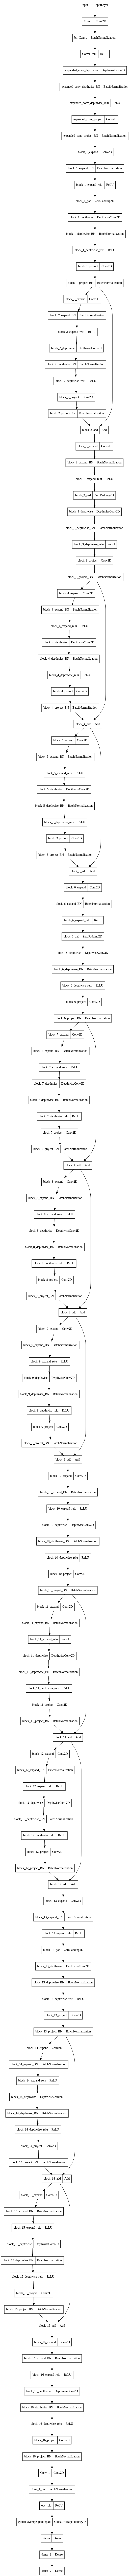

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']

    )

history = model.fit(
        train_images,
        validation_data = test_images,
        epochs=5
        )

Epoch 1/5
90/90 [==============================] - 5143s 57s/step - loss: 0.5387 - accuracy: 0.8604 - val_loss: 0.0811 - val_accuracy: 0.9756
Epoch 2/5
90/90 [==============================] - 3349s 37s/step - loss: 0.0668 - accuracy: 0.9816 - val_loss: 0.0657 - val_accuracy: 0.9800
Epoch 3/5
90/90 [==============================] - 3246s 36s/step - loss: 0.0330 - accuracy: 0.9906 - val_loss: 0.0242 - val_accuracy: 0.9922
Epoch 4/5
90/90 [==============================] - 3160s 35s/step - loss: 0.0283 - accuracy: 0.9931 - val_loss: 0.0320 - val_accuracy: 0.9900
Epoch 5/5
90/90 [==============================] - 3213s 36s/step - loss: 0.0109 - accuracy: 0.9976 - val_loss: 0.0151 - val_accuracy: 0.9944


In [ ]:
from tensorflow.keras.models import load_model

loaded_model_path = '/content/drive/My Drive/Project/results/mobilenetv2_model.h5'
model = load_model(loaded_model_path)

In [ ]:
results = model.evaluate(test_images, verbose=0)
print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 0.01428
Test Accuracy: 99.44%


In [ ]:
pred = model.predict(test_images)
pred=np.argmax(pred,axis=1)

29/29 [==============================] - 336s 12s/step


In [ ]:
pred_df = test_df.copy()
labels={}
for l,v in test_images.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

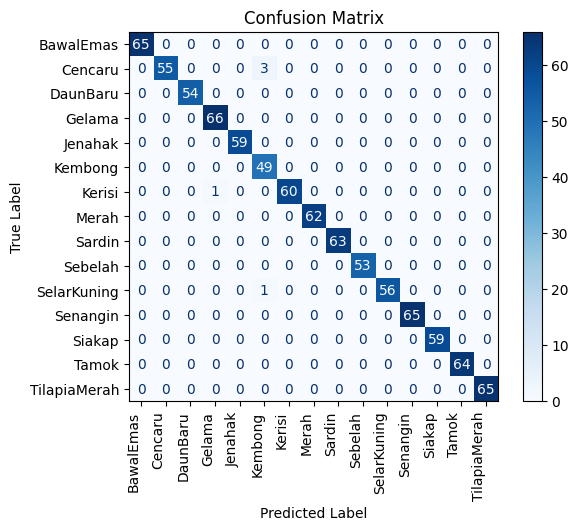

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(pred_df['label'], pred_df['pred'])

labels = np.unique(pred_df['label'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.xticks(rotation=90, ha='right')

plt.show()

In [ ]:
print(classification_report(pred_df['label'],pred_df['pred']))

              precision    recall  f1-score   support

   BawalEmas       1.00      1.00      1.00        65
     Cencaru       1.00      0.95      0.97        58
    DaunBaru       1.00      1.00      1.00        54
      Gelama       0.99      1.00      0.99        66
     Jenahak       1.00      1.00      1.00        59
     Kembong       0.92      1.00      0.96        49
      Kerisi       1.00      0.98      0.99        61
       Merah       1.00      1.00      1.00        62
      Sardin       1.00      1.00      1.00        63
     Sebelah       1.00      1.00      1.00        53
 SelarKuning       1.00      0.98      0.99        57
    Senangin       1.00      1.00      1.00        65
      Siakap       1.00      1.00      1.00        59
       Tamok       1.00      1.00      1.00        64
TilapiaMerah       1.00      1.00      1.00        65

    accuracy                           0.99       900
   macro avg       0.99      0.99      0.99       900
weighted avg       0.99   

In [ ]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

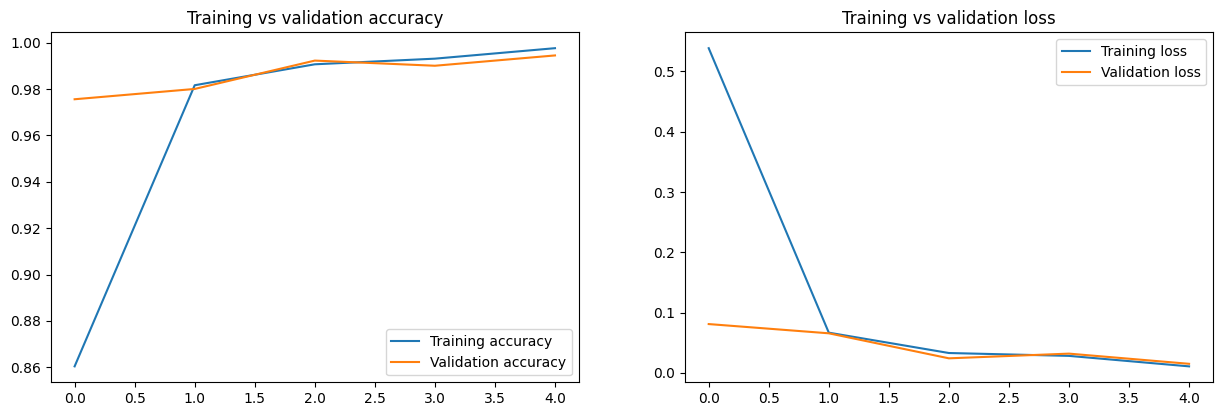

In [ ]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")


plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.show()

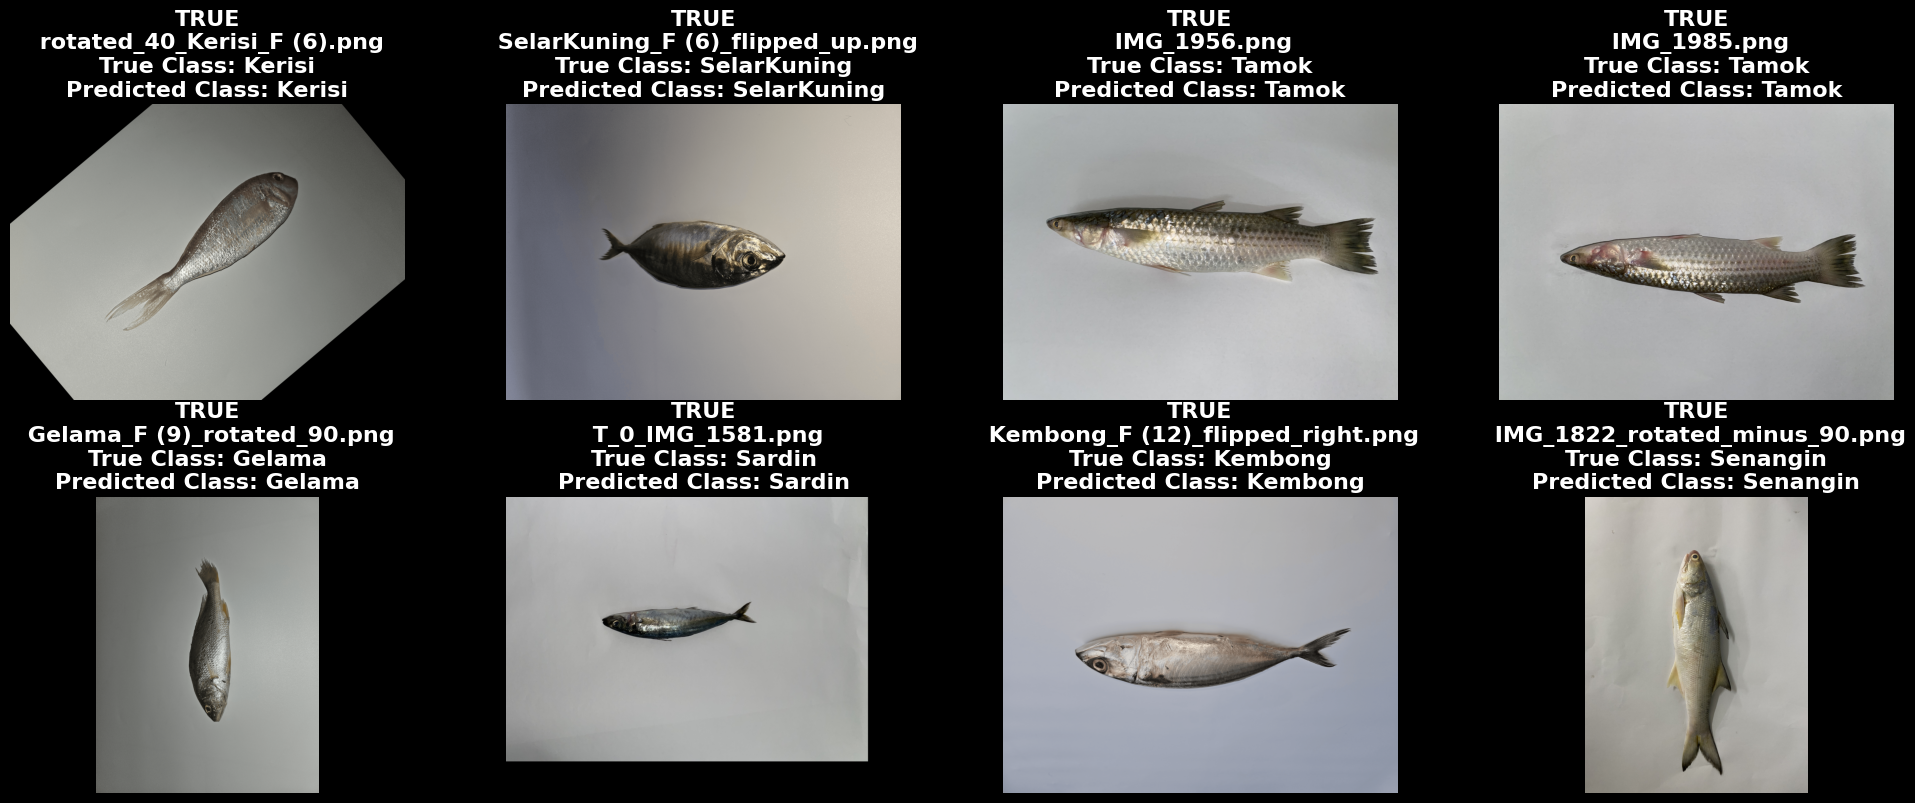

In [ ]:
import matplotlib.image as mpimg
#True prediciton
correct_preds = pred_df[pred_df['label'] == pred_df['pred']].head(8)

plt.figure(figsize=(20, 8), facecolor='black')

for i in range(min(8, len(correct_preds))):
    plt.subplot(2, 4, i + 1)
    img = mpimg.imread(correct_preds['path'].iloc[i])
    plt.imshow(img, cmap='viridis')
    title1 = correct_preds['path'].iloc[i].split('/')[-2]
    title2 = correct_preds['path'].iloc[i].split('/')[-1]
    title3 = correct_preds['pred'].iloc[i]
    plt.title(f'TRUE\n {title2}\nTrue Class: {title1}\nPredicted Class: {title3}', color='white', weight='bold', fontsize=16)
    plt.axis('off')

plt.tight_layout()
plt.show()


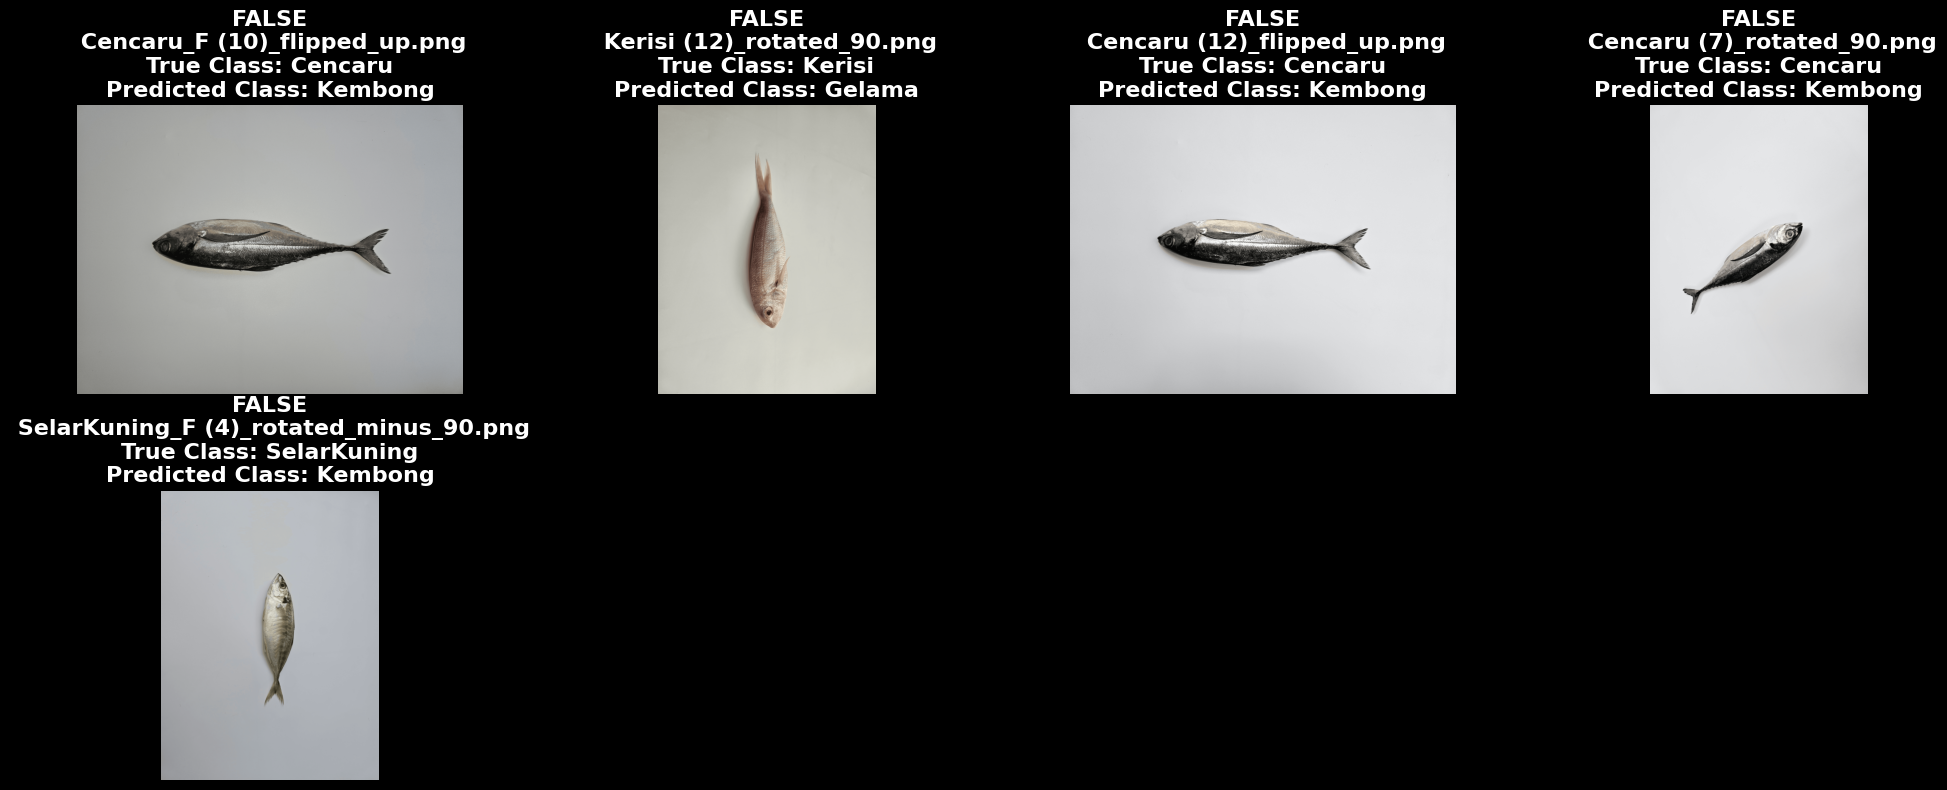

In [ ]:
#False prediction
incorrect_preds = pred_df[pred_df['label'] != pred_df['pred']].head(8)

plt.figure(figsize=(20, 8), facecolor='black')


for i in range(min(8, len(incorrect_preds))):
    plt.subplot(2, 4, i + 1)
    img = mpimg.imread(incorrect_preds['path'].iloc[i])
    plt.imshow(img, cmap='plasma')
    title1 = incorrect_preds['path'].iloc[i].split('/')[-2]
    title2 = incorrect_preds['path'].iloc[i].split('/')[-1]
    title3 = incorrect_preds['pred'].iloc[i]
    plt.title(f'FALSE\n {title2}\nTrue Class: {title1}\nPredicted Class: {title3}', color='white', weight='bold', fontsize=16)
    plt.axis('off')

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 149ms/step
The predicted class is: Jenahak
The predicted probability is: 0.56


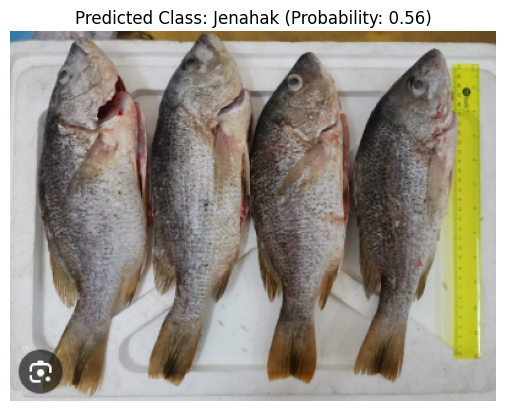

In [ ]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image
import numpy as np

# Path
single_image_path = '/content/drive/MyDrive/Project/ikan/Screenshot 2024-02-03 160006.png'

img = cv2.imread(single_image_path)
if img is None:
    raise ValueError(f"Error loading image at path: {single_image_path}")

# Convert to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Resize to match the input
img = cv2.resize(img, (224, 224))

# Preprocess the image
img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
img = np.expand_dims(img, axis=0)  # Add batch dimension


prediction = model.predict(img)
predicted_class_index = np.argmax(prediction)
predicted_class_label = labels[predicted_class_index]
predicted_probability = prediction[0, predicted_class_index]

print(f'The predicted class is: {predicted_class_label}')
print(f'The predicted probability is: {predicted_probability:.2f}')

# Display the image
img = mpimg.imread(single_image_path)
imgplot = plt.imshow(img)
plt.title(f'Predicted Class: {predicted_class_label} (Probability: {predicted_probability:.2f})')
plt.axis('off')
plt.show()


In [ ]:
model.save('mobilenetv2_model.h5')

### **VGG16**

In [ ]:
from tensorflow.keras.applications import VGG16
pretrained_model=VGG16(

    input_shape=(244,244,3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable=False

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
inputs =pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x=tf.keras.layers.Dropout(rate=0.3)(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Dense(64,activation='relu')(x)

outputs = tf.keras.layers.Dense(15, activation='softmax')(x)

pretrained_model = tf.keras.Model(inputs=inputs, outputs=outputs)

pretrained_model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 244, 244, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 244, 244, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 244, 244, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 122, 122, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 122, 122, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 122, 122, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 61, 61, 128)       0     

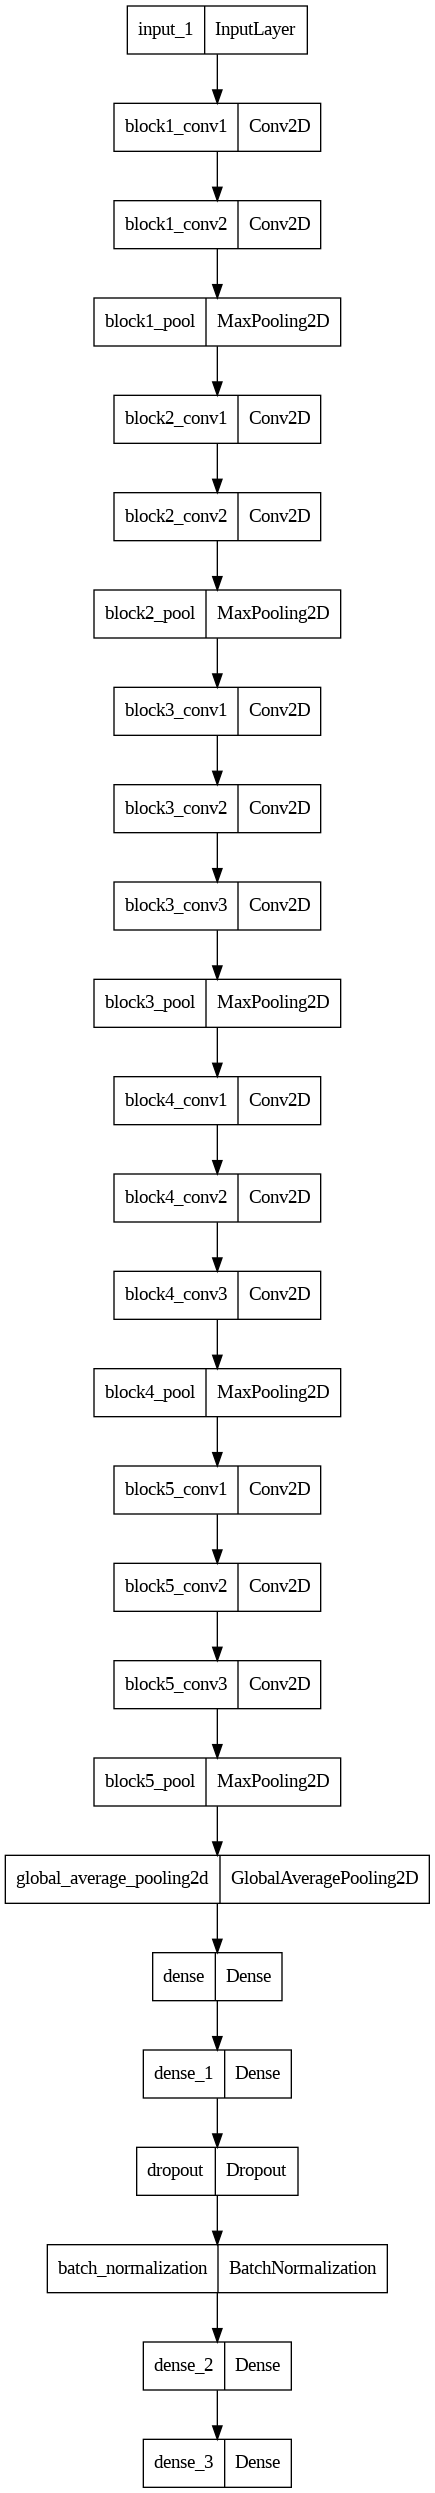

In [ ]:
tf.keras.utils.plot_model(pretrained_model)

In [ ]:
# optimizer = tf.keras.optimizers.legacy.Adam()

# pretrained_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# history_vgg16 = pretrained_model.fit(train_images, validation_data=val_images, epochs=10)

from tensorflow.keras.callbacks import ModelCheckpoint
import pickle

checkpoint_filepath = '/content/drive/My Drive/Project/checkpoints/model_checkpoint.h5'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

optimizer = tf.keras.optimizers.Adam()
pretrained_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history_vgg16 = pretrained_model.fit(
    train_images,
    validation_data=val_images,
    epochs=8,
    callbacks=[model_checkpoint_callback]
)



Epoch 1/10
90/90 [==============================] - ETA: 0s - loss: 1.9928 - accuracy: 0.3903 
Epoch 1: val_accuracy improved from -inf to 0.66806, saving model to /content/drive/My Drive/Project/checkpoints/model_checkpoint.h5
90/90 [==============================] - 3715s 41s/step - loss: 1.9928 - accuracy: 0.3903 - val_loss: 2.0593 - val_accuracy: 0.6681
Epoch 2/10
90/90 [==============================] - ETA: 0s - loss: 0.6564 - accuracy: 0.8483 
Epoch 2: val_accuracy improved from 0.66806 to 0.84583, saving model to /content/drive/My Drive/Project/checkpoints/model_checkpoint.h5
90/90 [==============================] - 3412s 38s/step - loss: 0.6564 - accuracy: 0.8483 - val_loss: 1.1266 - val_accuracy: 0.8458
Epoch 3/10
90/90 [==============================] - ETA: 0s - loss: 0.2806 - accuracy: 0.9205 
Epoch 3: val_accuracy improved from 0.84583 to 0.93056, saving model to /content/drive/My Drive/Project/checkpoints/model_checkpoint.h5
90/90 [==============================] - 3552s

In [ ]:
# Load the saved model
pretrained_model = tf.keras.models.load_model('/content/drive/My Drive/Project/checkpoints/model_checkpoint.h5')

In [ ]:
results_vgg16 = pretrained_model.evaluate(test_images, verbose=0)
print("Test Loss: {:.5f}".format(results_vgg16[0]))
print("Test Accuracy: {:.2f}%".format(results_vgg16[1] * 100))

Test Loss: 0.05640
Test Accuracy: 98.22%


In [ ]:
pred_vgg16 = pretrained_model.predict(test_images)
pred_vgg16 = np.argmax(pred_vgg16, axis=1)

29/29 [==============================] - 803s 27s/step


In [ ]:
pred_df_vgg16 = test_df.copy()
labels_vgg16 = {}
for l, v in test_images.class_indices.items():
    labels_vgg16.update({v: l})
pred_df_vgg16['pred'] = pred_vgg16
pred_df_vgg16['pred'] = pred_df_vgg16['pred'].apply(lambda x: labels_vgg16[x])

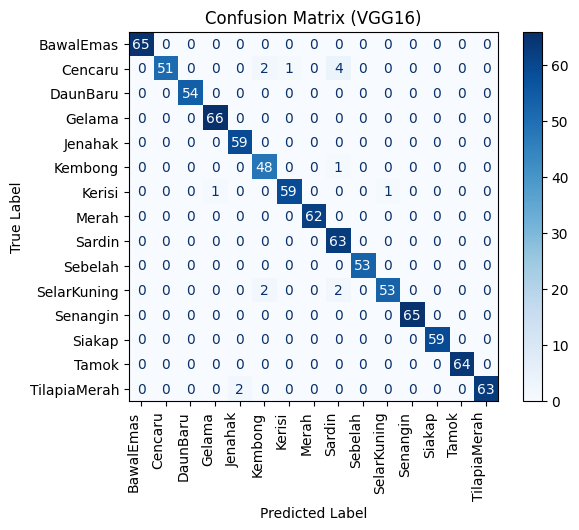

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_vgg16 = confusion_matrix(pred_df_vgg16['label'], pred_df_vgg16['pred'])

labels_vgg16 = np.unique(pred_df_vgg16['label'])
disp_vgg16 = ConfusionMatrixDisplay(confusion_matrix=cm_vgg16, display_labels=labels_vgg16)
disp_vgg16.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (VGG16)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=90, ha='right')
plt.show()

In [ ]:
print(classification_report(pred_df_vgg16['label'],pred_df_vgg16['pred']))

              precision    recall  f1-score   support

   BawalEmas       1.00      1.00      1.00        65
     Cencaru       1.00      0.88      0.94        58
    DaunBaru       1.00      1.00      1.00        54
      Gelama       0.99      1.00      0.99        66
     Jenahak       0.97      1.00      0.98        59
     Kembong       0.92      0.98      0.95        49
      Kerisi       0.98      0.97      0.98        61
       Merah       1.00      1.00      1.00        62
      Sardin       0.90      1.00      0.95        63
     Sebelah       1.00      1.00      1.00        53
 SelarKuning       0.98      0.93      0.95        57
    Senangin       1.00      1.00      1.00        65
      Siakap       1.00      1.00      1.00        59
       Tamok       1.00      1.00      1.00        64
TilapiaMerah       1.00      0.97      0.98        65

    accuracy                           0.98       900
   macro avg       0.98      0.98      0.98       900
weighted avg       0.98   

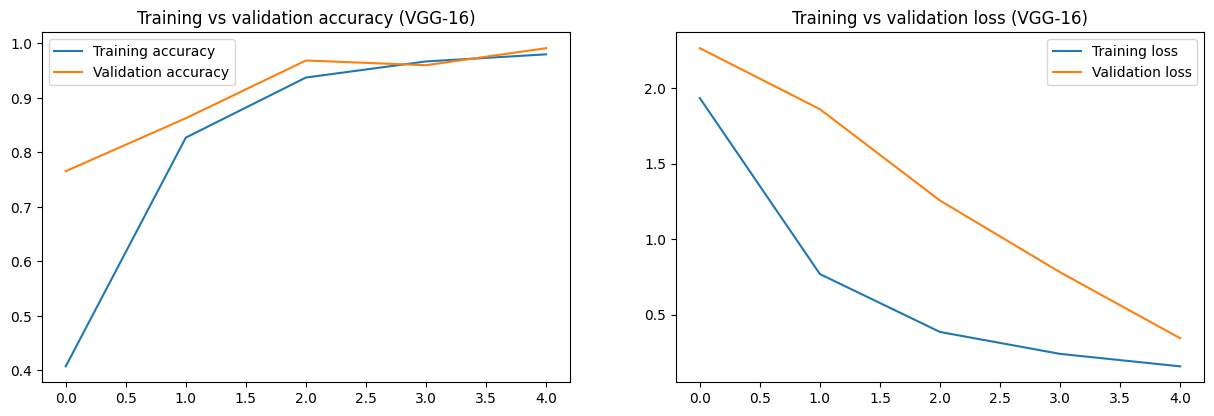

In [ ]:
accuracy = history_vgg16.history['accuracy']
val_accuracy  = history_vgg16.history['val_accuracy']

loss = history_vgg16.history['loss']
val_loss = history_vgg16.history['val_loss']

plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy (VGG-16)")


plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss (VGG-16)")

plt.show()

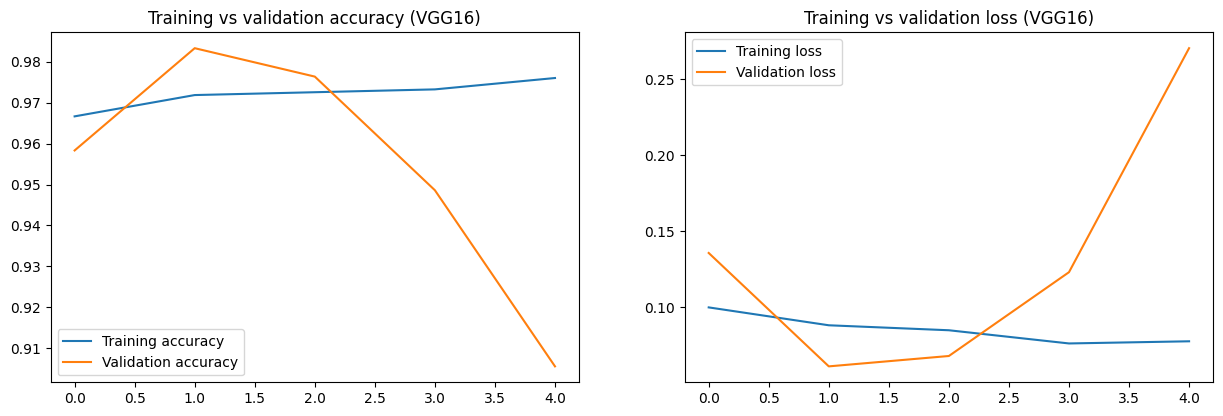

In [ ]:
import matplotlib.pyplot as plt
import pickle

# Load the training history
with open('/content/drive/My Drive/Project/checkpoints/history_vgg16.pkl', 'rb') as file:
    history_vgg16 = pickle.load(file)

# Access the metrics
accuracy = history_vgg16['accuracy']
val_accuracy = history_vgg16['val_accuracy']
loss = history_vgg16['loss']
val_loss = history_vgg16['val_loss']

# Plot the metrics
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label="Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy (VGG16)")

plt.subplot(2, 2, 2)
plt.plot(loss, label="Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss (VGG16)")

plt.show()


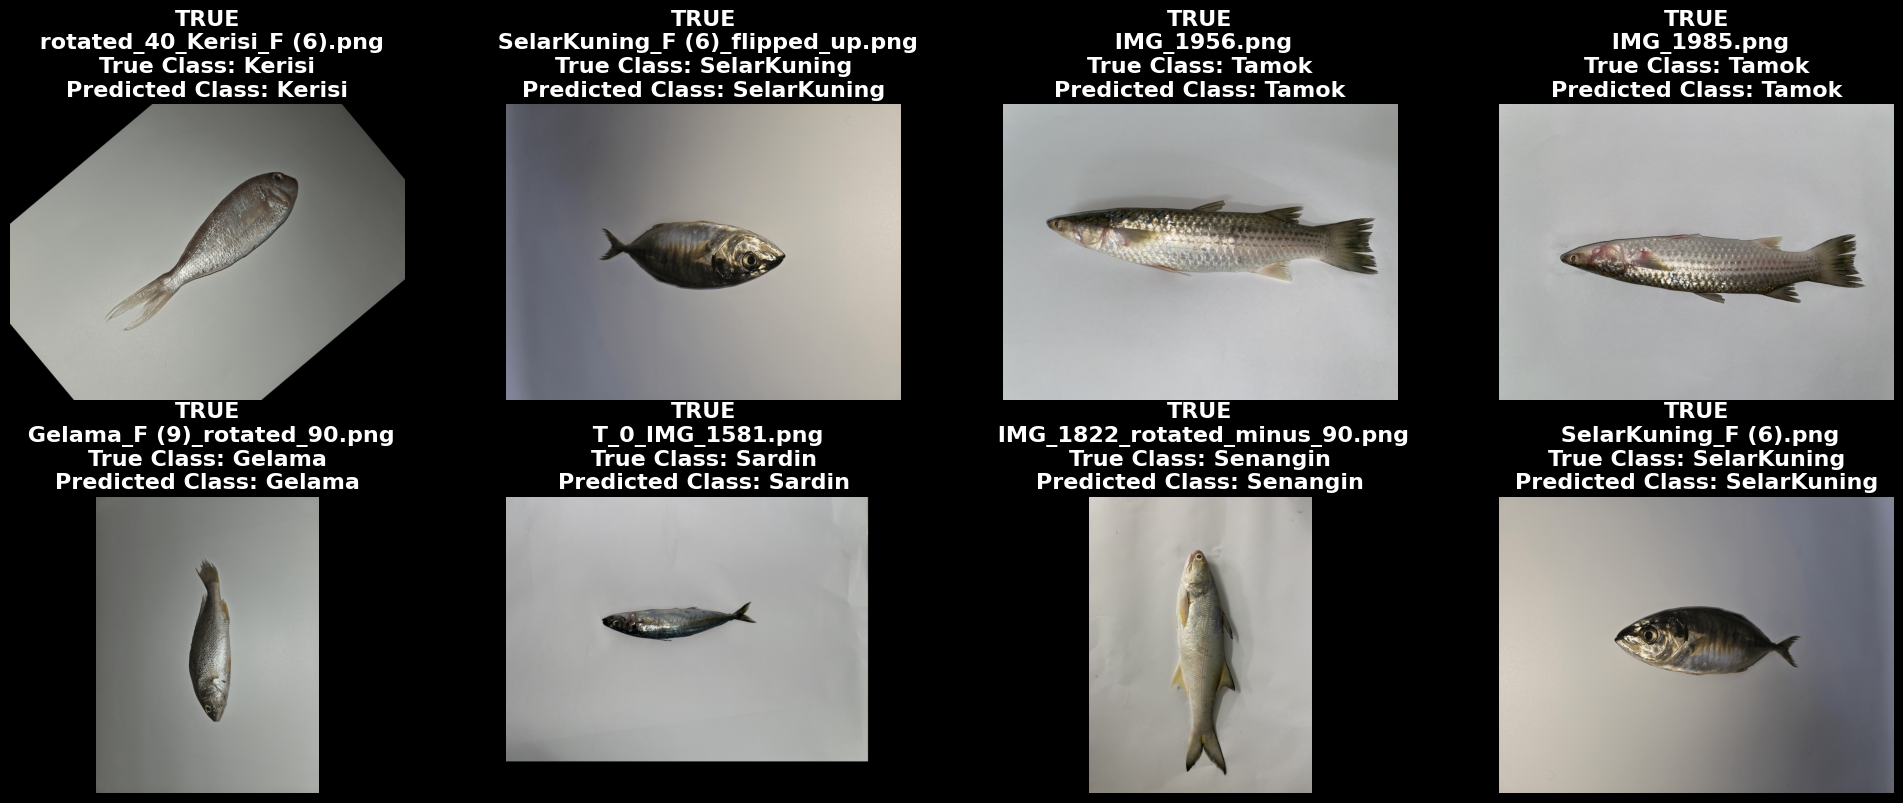

In [ ]:
# True prediction
import matplotlib.image as mpimg
correct_preds = pred_df_vgg16[pred_df_vgg16['label'] == pred_df_vgg16['pred']].head(8)

plt.figure(figsize=(20, 8), facecolor='black')

for i in range(min(8, len(correct_preds))):
    plt.subplot(2, 4, i + 1)
    img = mpimg.imread(correct_preds['path'].iloc[i])
    plt.imshow(img, cmap='viridis')
    title1 = correct_preds['path'].iloc[i].split('/')[-2]
    title2 = correct_preds['path'].iloc[i].split('/')[-1]
    title3 = correct_preds['pred'].iloc[i]
    plt.title(f'TRUE\n {title2}\nTrue Class: {title1}\nPredicted Class: {title3}', color='white', weight='bold', fontsize=16)
    plt.axis('off')

plt.tight_layout()
plt.show()


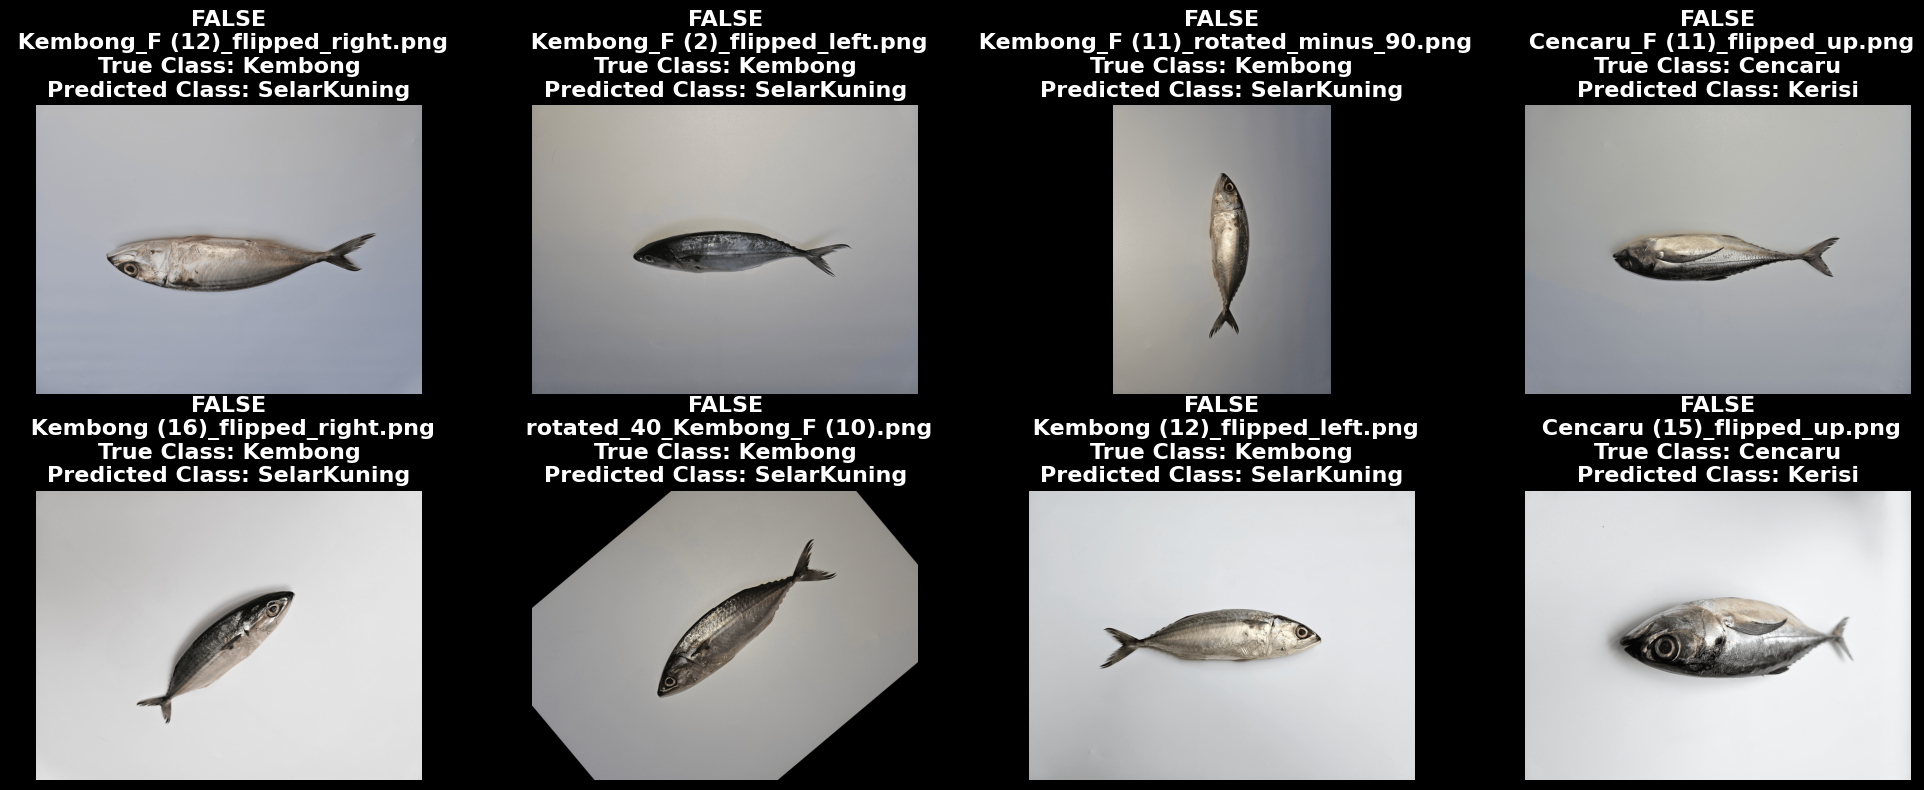

In [ ]:
# False prediction
incorrect_preds = pred_df_vgg16[pred_df_vgg16['label'] != pred_df_vgg16['pred']].head(8)

plt.figure(figsize=(20, 8), facecolor='black')

for i in range(min(8, len(incorrect_preds))):
    plt.subplot(2, 4, i + 1)
    img = mpimg.imread(incorrect_preds['path'].iloc[i])
    plt.imshow(img, cmap='plasma')
    title1 = incorrect_preds['path'].iloc[i].split('/')[-2]
    title2 = incorrect_preds['path'].iloc[i].split('/')[-1]
    title3 = incorrect_preds['pred'].iloc[i]
    plt.title(f'FALSE\n {title2}\nTrue Class: {title1}\nPredicted Class: {title3}', color='white', weight='bold', fontsize=16)
    plt.axis('off')

plt.tight_layout()
plt.show()


1/1 [==============================] - 1s 972ms/step
The predicted class is: Senangin
The predicted probability is: 1.00


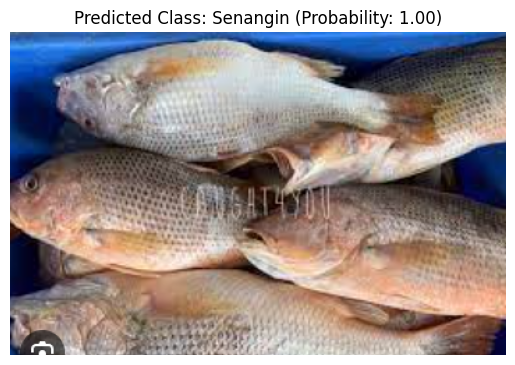

In [ ]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image
import numpy as np

# Path to the single image you want to predict
single_image_path = '/content/drive/My Drive/Project/ikan/Screenshot 2024-02-03 160550.png'

# Load the image with error handling
img = cv2.imread(single_image_path)
if img is None:
    raise ValueError(f"Error loading image at path: {single_image_path}")

# Convert to RGB format
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Resize the image to match the input size expected by the model (244x244)
img = cv2.resize(img, (244, 244))

# Preprocess the image
img = tf.keras.applications.vgg16.preprocess_input(img)
img = np.expand_dims(img, axis=0)  # Add batch dimension

# Make a prediction
prediction = pretrained_model.predict(img)

# Get the predicted class index
predicted_class_index = np.argmax(prediction)

# Map predicted class index to class label
predicted_class_label = labels_vgg16[predicted_class_index]

# Get the predicted probability for the predicted class
predicted_probability = prediction[0, predicted_class_index]

# Print the predicted class label and probability
print(f'The predicted class is: {predicted_class_label}')
print(f'The predicted probability is: {predicted_probability:.2f}')

# Display the image
img = mpimg.imread(single_image_path)
imgplot = plt.imshow(img)
plt.title(f'Predicted Class: {predicted_class_label} (Probability: {predicted_probability:.2f})')
plt.axis('off')
plt.show()


### **DenseNet121**

In [ ]:
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121
pretrained_densenet = DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg'
)
pretrained_densenet.trainable = False

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
inputs = pretrained_densenet.input
x = Flatten()(pretrained_densenet.output)
x = Dense(128, activation='relu')(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(15, activation='softmax')(x)


custom_densenet_model = Model(inputs=inputs, outputs=outputs)

custom_densenet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_3[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']      

In [ ]:
tf.keras.utils.plot_model(custom_densenet_model)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
custom_densenet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_densenet = custom_densenet_model.fit(
    train_images,
    validation_data=test_images,
    epochs=7,)

Epoch 1/7
90/90 [==============================] - 2760s 31s/step - loss: 0.6985 - accuracy: 0.8149 - val_loss: 0.1058 - val_accuracy: 0.9789
Epoch 2/7
90/90 [==============================] - 2623s 29s/step - loss: 0.0698 - accuracy: 0.9833 - val_loss: 0.0690 - val_accuracy: 0.9778
Epoch 3/7
90/90 [==============================] - 2586s 29s/step - loss: 0.0343 - accuracy: 0.9931 - val_loss: 0.0383 - val_accuracy: 0.9900
Epoch 4/7
90/90 [==============================] - 2588s 29s/step - loss: 0.0193 - accuracy: 0.9955 - val_loss: 0.0219 - val_accuracy: 0.9944
Epoch 5/7
90/90 [==============================] - 2606s 29s/step - loss: 0.0080 - accuracy: 0.9997 - val_loss: 0.0160 - val_accuracy: 0.9944
Epoch 6/7
90/90 [==============================] - 2650s 29s/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.0141 - val_accuracy: 0.9978
Epoch 7/7
90/90 [==============================] - 2607s 29s/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0102 - val_accuracy: 0.9978


In [ ]:
custom_densenet_model.save('custom_densenet_model.h5')

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model_path = '/content/drive/My Drive/Project/results/custom_densenet_model (1).h5'
custom_densenet_model = load_model(loaded_model_path)


In [ ]:
results_densenet = custom_densenet_model.evaluate(test_images, verbose=0)
print("Test Loss: {:.5f}".format(results_densenet[0]))
print("Test Accuracy: {:.2f}%".format(results_densenet[1] * 100))

Test Loss: 0.01018
Test Accuracy: 99.78%


In [ ]:
pred_densenet = custom_densenet_model.predict(test_images)
pred_densenet = np.argmax(pred_densenet, axis=1)

29/29 [==============================] - 477s 16s/step


In [ ]:
pred_df_densenet = test_df.copy()
labels_densenet = {}

for l, v in test_images.class_indices.items():
    labels_densenet.update({v: l})

pred_df_densenet['pred'] = pred_densenet
pred_df_densenet['pred'] = pred_df_densenet['pred'].apply(lambda x: labels_densenet[x])

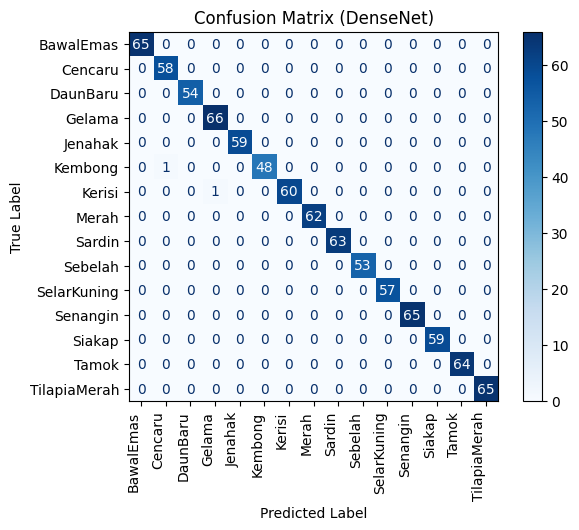

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm_densenet = confusion_matrix(pred_df_densenet['label'], pred_df_densenet['pred'])

labels_densenet = np.unique(pred_df_densenet['label'])
disp_densenet = ConfusionMatrixDisplay(confusion_matrix=cm_densenet, display_labels=labels_densenet)
disp_densenet.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (DenseNet)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=90, ha='right')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(pred_df_densenet['label'], pred_df_densenet['pred']))

              precision    recall  f1-score   support

   BawalEmas       1.00      1.00      1.00        65
     Cencaru       0.98      0.98      0.98        58
    DaunBaru       1.00      1.00      1.00        54
      Gelama       1.00      1.00      1.00        66
     Jenahak       1.00      1.00      1.00        59
     Kembong       0.98      0.98      0.98        49
      Kerisi       1.00      1.00      1.00        61
       Merah       1.00      1.00      1.00        62
      Sardin       1.00      1.00      1.00        63
     Sebelah       1.00      1.00      1.00        53
 SelarKuning       1.00      1.00      1.00        57
    Senangin       1.00      1.00      1.00        65
      Siakap       1.00      1.00      1.00        59
       Tamok       1.00      1.00      1.00        64
TilapiaMerah       1.00      1.00      1.00        65

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00   

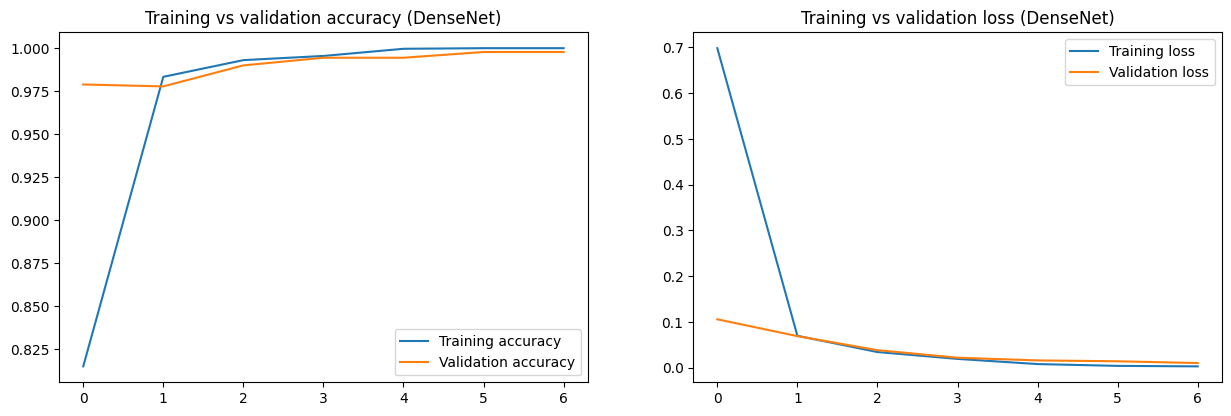

In [ ]:
accuracy = history_densenet.history['accuracy']
val_accuracy = history_densenet.history['val_accuracy']

loss = history_densenet.history['loss']
val_loss = history_densenet.history['val_loss']

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label="Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy (DenseNet)")

plt.subplot(2, 2, 2)
plt.plot(loss, label="Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss (DenseNet)")

plt.show()

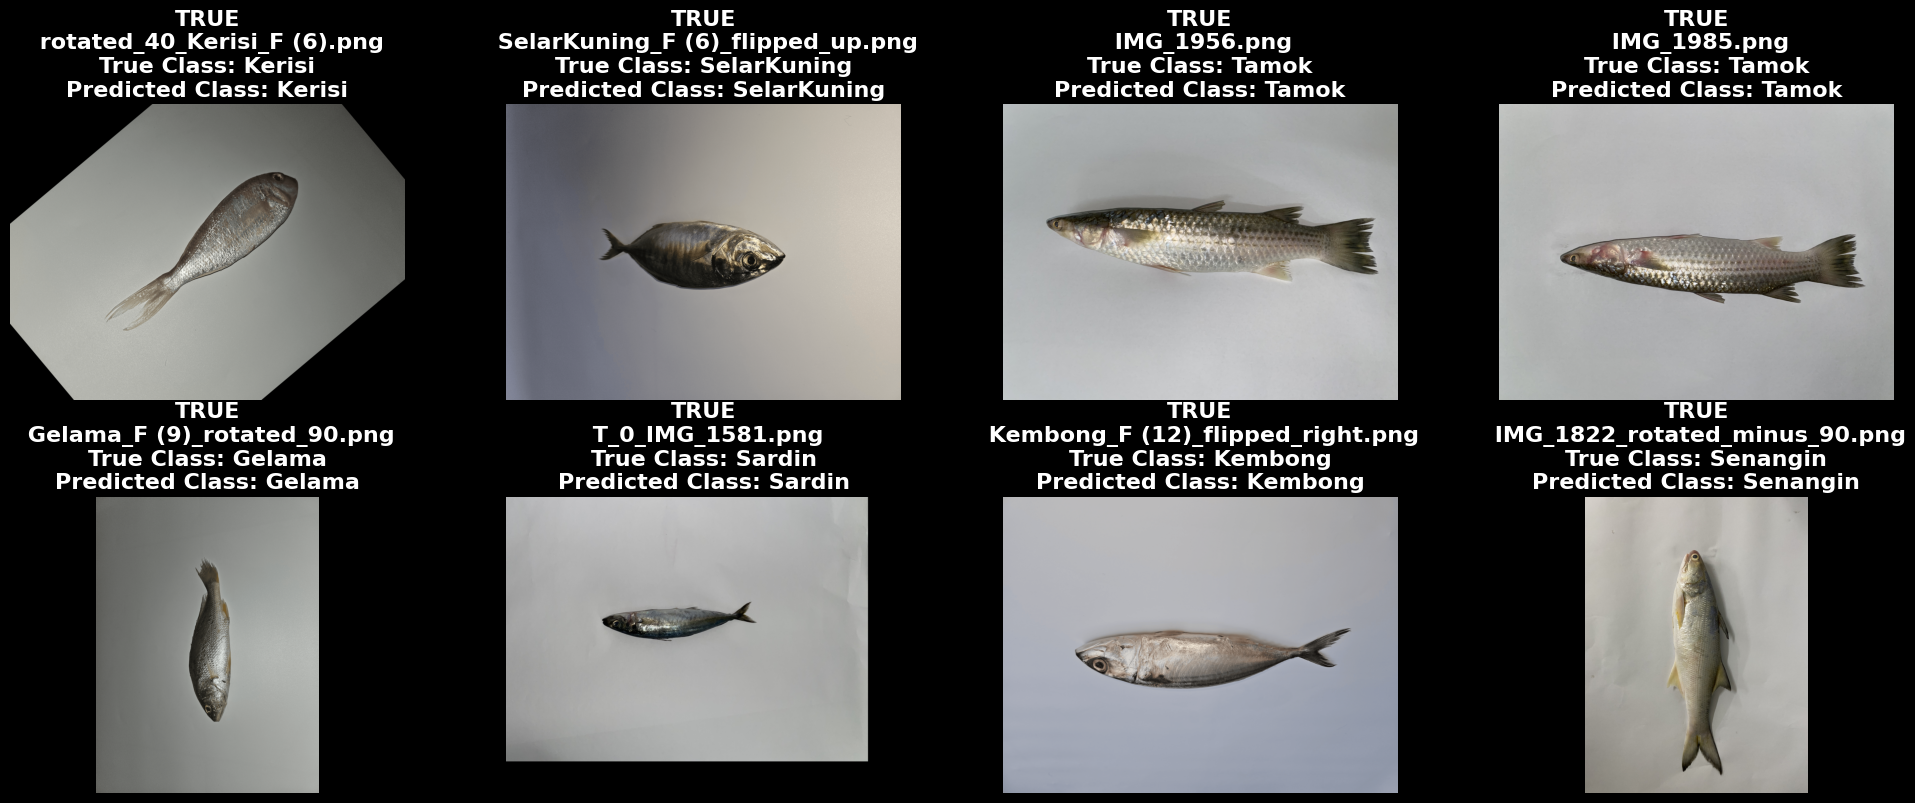

In [ ]:
import matplotlib.image as mpimg

# True prediction
correct_preds_densenet = pred_df_densenet[pred_df_densenet['label'] == pred_df_densenet['pred']].head(8)

plt.figure(figsize=(20, 8), facecolor='black')

for i in range(min(8, len(correct_preds_densenet))):
    plt.subplot(2, 4, i + 1)
    img = mpimg.imread(correct_preds_densenet['path'].iloc[i])
    plt.imshow(img, cmap='viridis')
    title1 = correct_preds_densenet['path'].iloc[i].split('/')[-2]
    title2 = correct_preds_densenet['path'].iloc[i].split('/')[-1]
    title3 = correct_preds_densenet['pred'].iloc[i]
    plt.title(f'TRUE\n {title2}\nTrue Class: {title1}\nPredicted Class: {title3}', color='white', weight='bold', fontsize=16)
    plt.axis('off')

plt.tight_layout()
plt.show()


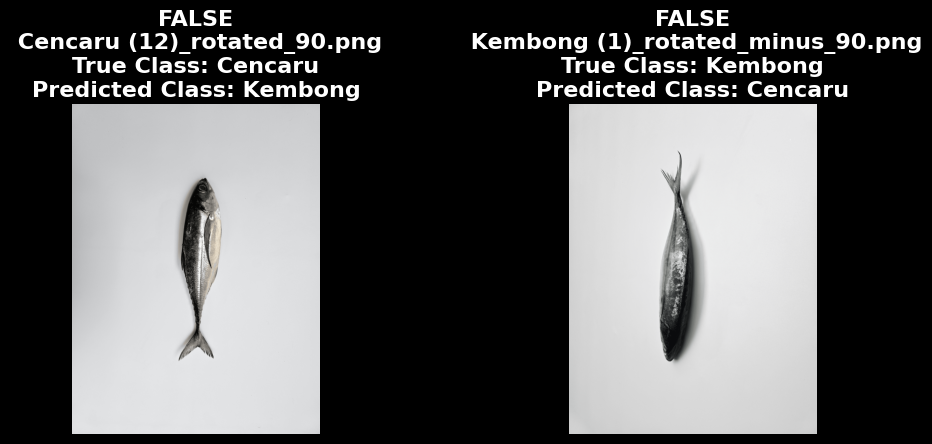

In [ ]:
# False prediction
incorrect_preds_densenet = pred_df_densenet[pred_df_densenet['label'] != pred_df_densenet['pred']].head(8)

plt.figure(figsize=(20, 8), facecolor='black')

for i in range(min(8, len(incorrect_preds_densenet))):
    plt.subplot(2, 4, i + 1)
    img = mpimg.imread(incorrect_preds_densenet['path'].iloc[i])
    plt.imshow(img, cmap='plasma')
    title1 = incorrect_preds_densenet['path'].iloc[i].split('/')[-2]
    title2 = incorrect_preds_densenet['path'].iloc[i].split('/')[-1]
    title3 = incorrect_preds_densenet['pred'].iloc[i]
    plt.title(f'FALSE\n {title2}\nTrue Class: {title1}\nPredicted Class: {title3}', color='white', weight='bold', fontsize=16)
    plt.axis('off')

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 476ms/step
The predicted class is: BawalEmas
The predicted probability is: 0.88


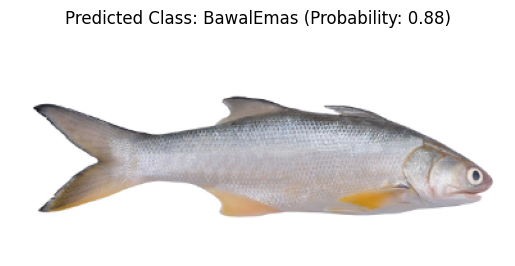

In [ ]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image
import numpy as np

# Path to the single image you want to predict
single_image_path = '/content/drive/My Drive/Project/ikan/Screenshot 2024-01-18 195218.png'

# Load the image with error handling
img = cv2.imread(single_image_path)
if img is None:
    raise ValueError(f"Error loading image at path: {single_image_path}")

# Convert to RGB format
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Resize the image to match the input size expected by the model (224x224 for DenseNet)
img = cv2.resize(img, (224, 224))

# Preprocess the image
img = tf.keras.applications.densenet.preprocess_input(img)
img = np.expand_dims(img, axis=0)  # Add batch dimension

# Make a prediction
prediction = custom_densenet_model.predict(img)

# Get the predicted class index
predicted_class_index = np.argmax(prediction)

# Map predicted class index to class label
predicted_class_label = labels_densenet[predicted_class_index]

# Get the predicted probability for the predicted class
predicted_probability = prediction[0, predicted_class_index]

# Print the predicted class label and probability
print(f'The predicted class is: {predicted_class_label}')
print(f'The predicted probability is: {predicted_probability:.2f}')

# Display the image
img = mpimg.imread(single_image_path)
imgplot = plt.imshow(img)
plt.title(f'Predicted Class: {predicted_class_label} (Probability: {predicted_probability:.2f})')
plt.axis('off')
plt.show()